DC2 DESI Selection
==================

Script for selecting "spectroscopic" reference objects from DC2 era datasets.

This script is similar to the SelectDESIReferenceSample notebook but makes better use of the GCR and outputs dataproducts for ingestion into the GCR.

This dataset is meant to mimic the DESI selection as a function of redshift for 4 samples: Luminous Red Galaixes (LRGs), Emission Line Galaxies (ELGs), a magnitude limited sample, and high redshift quasars (QSOs).

Numbers are from the DESI final design document: http://desi.lbl.gov/wp-content/uploads/2014/04/fdr-science-biblatex.pdf and from private communication with Jeff Newman and Rongpu Zhou.

This code is currently structured to work on protoDC2 only. Some more scripting will be required when the full DC2 truth dataset becomes available.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import GCRCatalogs
from GCR import GCRQuery

In [2]:
print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)

GCRCatalogs = 0.10.0 | GCR = 0.8.7


In [3]:
bin_edges = np.concatenate(
    [np.arange(0.60, 1.95, 0.1),
     [2.02, 2.22, 2.34, 2.52, 2.66,
      2.84, 2.98, 3.16, 3.30, 3.48,
      3.62, 3.78, 3.94, 4.10]])
delta_zs = bin_edges[1:] - bin_edges[:-1]
# Initial density values are in units, N / (deg^2 dz)
# hence multiplying by the redshift bin width.
ELG_density = np.array( # units: N / degree^2
    [ 309, 2269, 1923, 2094, 1441, 1353,  523,  466,
      329,  126,    0,    0, 0,    0,    0,    0,
        0,    0,    0,    0, 0,    0,    0,    0,
        0,    0,    0]) * delta_zs
QSO_density = np.array(# units: N / degree^2
    [47, 55, 61, 67, 72, 76, 80, 83,
     85, 87, 87, 87, 86, 82, 69, 53,
     43, 37, 31, 26, 21, 16, 13,  9,
      7,  5,  3]) * delta_zs

Rongpu kindly provided more recent density estimates for LRGs detected in DESI. These are provided in redshift bins with a width of delta z=0.01. For protoDC2 this is currently to fine of a binning for the ammount of data available so we smooth it to a binning similar to that of the other densities, delta_z=0.1.

In [4]:
lrg_density = np.loadtxt(
    '/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/protoDC2v5/DESI_reference_redshifts/'
    'lrg_densities_20180725.txt')
lrg_smoothed_bin_edges = np.arange(0.25, 1.26, 0.1)
print(lrg_smoothed_bin_edges)
lrg_smoothed_densities = np.zeros(len(lrg_smoothed_bin_edges) - 1)
for bin_idx in range(10):
    lrg_smoothed_densities[bin_idx] = lrg_density[
        10*bin_idx:10 * (bin_idx + 1), 2].sum()

[0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25]


Load in the current GCRCatalog version. We will likely always create the initial value selections on a smaller set of the data.

In [5]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

Create a simple variable for selecting QSO like objects. Here we just make a variable that gives large values to galaxies with large central black holes and large Eddington ratios. 

In [6]:
def qsoness(mass, ratio):
    """Simple variable identifying how qso like an object is.
    
    Parameters
    ----------
    mass : `float`
        Black hole mass
    ratio : `float`
        Black hole eddington ratio
        
    Returns
    -------
    qsoness : `float`
        Simple multication of mass * ratio.
    """
    return mass * ratio

Add our new variable to the catalog so we may select on it.

In [7]:
catalog.add_derived_quantity('qsoness', qsoness, 'blackHoleMass', 'blackHoleEddingtonRatio')

Below is the same as from the previous notebook (SelectDESIReferenceSamples). The small change here is that we will use the add_derived_quantity feature of remove objects that we have already identified as to be selected to get 4 independent samples of Reference objects.

In [8]:
def create_redshift_stellar_prop_selection(z_bin_mins,
                                           z_bin_maxes,
                                           goal_number_densities,
                                           mag_name='mag_r_lsst',
                                           mag_lim=23.4,
                                           not_columns=None,
                                           selection='qsoness'):
    """Compute star formation rate or stellar mass cuts in redshifts bins given a
    set of bin edges and expected densities.
    
    Paramters
    ---------
    z_bin_mins : `float` array-like
        Minimum bin redshifts.
    z_bin_maxes : `float` array-like
        Maximum bin redshifts.
    goal_number_densities : `float` array-like
        Number of expected objects per redshift bin. Should be in units counts.
    mag_name : `str`
        Name of the magnitude column to cut on.
    mag_lim : `float`
        Maximum value of the magnitude obseved in mag_name.
    not_columns : `dict`
        Dictionary of float arrays from a pervious selection run in this method.
    selection : `string`
        Column to select stellar properites. Valid choices are stellar_mass and
        totalStarFormationRation.
        
    Returns
    -------
    output : `dict`
        Dictionary of bin edges.
    """
    
    columns = [mag_name, 'redshift', selection]
    
    #Pre-cut selections. Magnitude cut avoids duplication of objects from the DESI
    # magnitude limiting cut.
    start_cut = [
        GCRQuery('%s < %.1f' % (mag_name, mag_lim)),
        GCRQuery('redshift > %.2f' % np.min(z_bin_mins)),
        GCRQuery('redshift <= %.2f' % np.max(z_bin_maxes)),
        GCRQuery('mag_r_lsst >= 19.5')
    ]
    if not_columns is not None:
        for not_column in not_columns:
            start_cut.append(GCRQuery('%s' % not_column))

    data = catalog.get_quantities(columns, filters=start_cut)
    
    #Initialize data output dict.
    output = {"z_min": z_bin_mins,
              "z_max": z_bin_maxes,
              "n_goal": goal_number_densities,
              "mag_lim": mag_lim,
              selection: np.full(len(z_bin_maxes), 10 ** 30),
              "mag_name": mag_name}
        
    for bin_idx, (z_min, z_max, n_goal) in enumerate(
            zip(z_bin_mins, z_bin_maxes, goal_number_densities)):
        
        if n_goal <= 0:
            continue

        mask = np.logical_and(data['redshift'] > z_min,
                              data['redshift'] <= z_max)
        
        #If an input dict has been provided, select on totalStarFormationRate
        #as defined by the dictionary. This allows for the removal of objects
        #previously selected from a sample making each selection a set of
        #independent objects.
        stellar_array = data[selection][mask]

        if len(stellar_array) == 0:
            continue
        elif len(stellar_array) < n_goal:
            n_goal = len(stellar_array)
        stellar_array.sort()
        
        output[selection][bin_idx] = stellar_array[-np.int(np.ceil(n_goal))]
            
    return output

Save the output dictionary of cuts vs redshift.

In [9]:
qso_dict = create_redshift_stellar_prop_selection(
    bin_edges[:-1],
    bin_edges[1:],
    QSO_density * catalog.sky_area,
    selection='qsoness',
    mag_name="mag_r_lsst",
    mag_lim=23.4)

Create a new funciton for use in the derive quantities that selects objects that are **not** QSOs. When selecting the next set of objects, we want to exclude the previously selected set. The current GCR seems to not like bitwise inverting derived boolean variables hence we right this derived column as things that are not qsos.

In [10]:
def not_qsoselection(redshift, mag, mag_r, qsoness):
    """Create a selection of objects that do not pass our selection for QSOs.
    
    For use in the GCR.
    
    Parameters
    ----------
    redshift : `float` array-like
        Redshift of the object
    mag : `float` array-like
        Magnitude the object is selected with
    mag_r : `float` array-like
        r band magnitude. Used to select out a magnitude limited sample.
    qsoness : `float` array-like
        Variable defining what is a qso. Larger is more QSO like.
    
    Returns
    -------
    is_not_qso : `bool` array-like
        Boolean defining objects that do not pass the selection.
    """
    mask =  mag_r > 19.5
    mask = np.logical_and(mag < qso_dict['mag_lim'], mask)
    
    z_min = qso_dict['z_min'].min()
    z_max = qso_dict['z_min'].max()
    mask = np.logical_and(mask, redshift > z_min)
    mask = np.logical_and(mask, redshift < z_max)
    
    z_bin_idxes = np.searchsorted(qso_dict['z_min'], redshift) - 1
    
    min_qsoness = qso_dict['qsoness'][z_bin_idxes]
    mask = np.logical_and(qsoness > min_qsoness, mask)
    
    return np.logical_not(mask)

In [11]:
catalog.add_derived_quantity('not_qsoselection',
                             not_qsoselection,
                             'redshift', 'mag_r_lsst', 'mag_r_lsst', 'qsoness')

Repeat but for a fictional ELG  and LRG samples. Note that we use the derived 'not' flags to assure ourselves that we are not duplicating objects.

In [12]:
elg_dict = create_redshift_stellar_prop_selection(
    bin_edges[:-1],
    bin_edges[1:],
    ELG_density * catalog.sky_area,
    not_columns=['not_qsoselection'],
    selection='totalStarFormationRate',
    mag_name="mag_r_lsst",
    mag_lim=23.4)

Same as before but now selecting things that did do not pass our ELG selection.

In [13]:
def not_elgselection(redshift, mag, mag_r, sfr, not_qso):
    """Create a selection of objects that do not pass our selection for QSOs.
    
    For use in the GCR
    
    Parameters
    ----------
    redshift : `float` array-like
        Redshift of the object
    mag : `float` array-like
        Magnitude the object is selected with
    mag_r : `float` array-like
        r band magnitude. Used to select out a magnitude limited sample.
    sfr : `float` array-like
        Star formation rate of objects.
    not_qso : `bool` array-like
        Boolean defining what is not a qso.
    
    
    Returns
    -------
    is_not_elg : `bool` array-like
        Boolean defining objects that do not pass the selection.
    """
    mask =  mag_r > 19.5
    mask = np.logical_and(mag < elg_dict['mag_lim'], mask)
    mask = np.logical_and(not_qso, mask)
    
    z_min = elg_dict['z_min'].min()
    z_max = elg_dict['z_min'].max()
    mask = np.logical_and(mask, redshift > z_min)
    mask = np.logical_and(mask, redshift < z_max)
    
    z_bin_idxes = np.searchsorted(elg_dict['z_min'], redshift) - 1
    
    min_sfr = elg_dict['totalStarFormationRate'][z_bin_idxes]
    mask = np.logical_and(sfr > min_sfr, mask)
    
    return np.logical_not(mask)

In [14]:
catalog.add_derived_quantity('not_elgselection',
                             not_elgselection,
                             'redshift',
                             'mag_r_lsst',
                             'mag_r_lsst',
                             'totalStarFormationRate',
                             'not_qsoselection')


In [15]:
lrg_dict = create_redshift_stellar_prop_selection(
    lrg_smoothed_bin_edges[:-1],
    lrg_smoothed_bin_edges[1:],
    lrg_smoothed_densities * catalog.sky_area,
    not_columns=['not_qsoselection', 'not_elgselection'],
    selection='stellar_mass',
    mag_name="mag_z_lsst",
    mag_lim=23.0)

In [16]:
def not_lrgselection(redshift, mag, mag_r, stm, not_qso, not_elg):
    """Create a selection of objects that do not pass our selection for QSOs.
    
    For use in the GCR
    
    Parameters
    ----------
    redshift : `float` array-like
        Redshift of the object
    mag : `float` array-like
        Magnitude the object is selected with
    mag_r : `float` array-like
        r band magnitude. Used to select out a magnitude limited sample.
    sfr : `float` array-like
        Star formation rate of objects.
    not_qso : `bool` array-like
        Boolean defining what is not a qso.
    not_elg : `bool` array-like
        Boolean defining what is not a elg.
    
    
    Returns
    -------
    is_not_lrg : `bool` array-like
        Boolean defining objects that do not pass the selection.
    """
    mask =  mag_r > 19.5
    mask = np.logical_and(mag < lrg_dict['mag_lim'], mask)
    mask = np.logical_and(not_qso, mask)
    mask = np.logical_and(not_elg, mask)
    
    z_min = lrg_dict['z_min'].min()
    z_max = lrg_dict['z_min'].max()
    mask = np.logical_and(mask, redshift > z_min)
    mask = np.logical_and(mask, redshift < z_max)
    
    z_bin_idxes = np.searchsorted(lrg_dict['z_min'], redshift) - 1
    
    min_stm = lrg_dict['stellar_mass'][z_bin_idxes]
    mask = np.logical_and(stm > min_stm, mask)
    
    return np.logical_not(mask)

In [17]:
catalog.add_derived_quantity('not_lrgselection',
                             not_lrgselection,
                             'redshift',
                             'mag_z_lsst',
                             'mag_r_lsst',
                             'stellar_mass',
                             'not_qsoselection',
                             'not_elgselection')

Add a simple selection for a DESI like magnitude limited sample.

In [18]:
def magnitude_limit(mag):
    return mag < 19.5

catalog.add_derived_quantity('mag_limit',
                             magnitude_limit,
                             'mag_r_lsst')

Below we write a simple set of functions to load our new derived columns and write the output for later loading into GCRCatalogs.

In [19]:
import os
base_dir = '/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/COSMODC2v1.1.4/PZCalibrate_small'

In [20]:
pzCalib_iter = catalog.get_quantities(['not_qsoselection', 'not_elgselection',
                                       'not_lrgselection', 'mag_limit'],
                                      return_iterator=True)
fpath_iterator = catalog._healpix_files.values()

In [21]:
"""
for data, fpath_original in zip(pzCalib_iter, fpath_iterator):
    pz_calib_out = dict()

    pz_calib_out['QSO'] = np.logical_not(data['not_qsoselection'])

    pz_calib_out['ELG'] = np.logical_not(data['not_elgselection'])
    mask = np.logical_or(pz_calib_out['QSO'], pz_calib_out['ELG'])

    pz_calib_out['LRG'] = np.logical_not(data['not_lrgselection'])
    mask = np.logical_or(mask, pz_calib_out['LRG'])

    pz_calib_out['MagLim'] = data['mag_limit']
    mask = np.logical_or(mask, pz_calib_out['MagLim'])
    
    pz_calib_out['AllReferences'] = mask
    
    fname_base, ext = os.path.splitext(os.path.basename(fpath_original))
    assert ext == '.hdf5' # this is just a sanity check
    fpath = os.path.join(base_dir, fname_base + '_pz_calib')
    
    np.savez(fpath, **pz_calib_out)
"""

"\nfor data, fpath_original in zip(pzCalib_iter, fpath_iterator):\n    pz_calib_out = dict()\n\n    pz_calib_out['QSO'] = np.logical_not(data['not_qsoselection'])\n\n    pz_calib_out['ELG'] = np.logical_not(data['not_elgselection'])\n    mask = np.logical_or(pz_calib_out['QSO'], pz_calib_out['ELG'])\n\n    pz_calib_out['LRG'] = np.logical_not(data['not_lrgselection'])\n    mask = np.logical_or(mask, pz_calib_out['LRG'])\n\n    pz_calib_out['MagLim'] = data['mag_limit']\n    mask = np.logical_or(mask, pz_calib_out['MagLim'])\n    \n    pz_calib_out['AllReferences'] = mask\n    \n    fname_base, ext = os.path.splitext(os.path.basename(fpath_original))\n    assert ext == '.hdf5' # this is just a sanity check\n    fpath = os.path.join(base_dir, fname_base + '_pz_calib')\n    \n    np.savez(fpath, **pz_calib_out)\n"

Test out the redshift, magnitude, and color distributions of the output objects. For the most part things look reasonable. The things that are supposed to be a given color are that color (red, blue), the magnitude distros line up with what was selected, and the redshift distributions are as expected, modulo a roll off at the highest redshift due to simulation itself losing objects.

In [22]:
magLim = catalog.get_quantities(['redshift', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst'],
                                 filters=[GCRQuery('mag_limit')])
qsos = catalog.get_quantities(['redshift', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst'],
                               filters=[GCRQuery('not_qsoselection == 0')])
elgs = catalog.get_quantities(['redshift', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst'],
                               filters=[GCRQuery('not_elgselection == 0')])
lrgs = catalog.get_quantities(['redshift', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst'],
                               filters=[GCRQuery('not_lrgselection == 0')])

Text(0,0.5,'N')

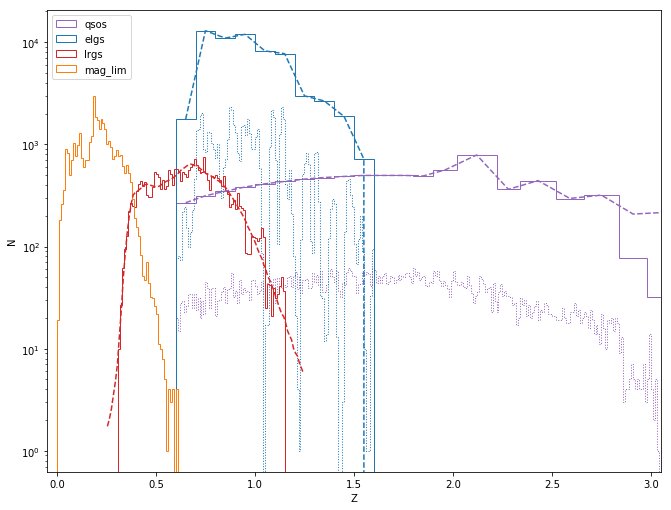

In [23]:
plt.figure(figsize=(11, 8.5))
plt.hist(qsos['redshift'], bins=bin_edges, histtype='step', label='qsos',
         color='C4')
plt.hist(qsos['redshift'], bins=np.arange(0, 3.05, 0.01), histtype='step',
         color='C4', ls=':')
plt.plot(bin_edges[:-1] + delta_zs / 2.0, QSO_density * catalog.sky_area, ls='--',
         color='C4')
plt.hist(elgs['redshift'], bins=bin_edges, histtype='step', label='elgs',
         color='C0')
plt.hist(elgs['redshift'], bins=np.arange(0, 3.05, 0.01), histtype='step',
         color='C0', ls=':')
plt.plot(bin_edges[:-1] + delta_zs / 2.0, ELG_density * catalog.sky_area, ls='--',
         color='C0')
plt.hist(lrgs['redshift'], bins=np.arange(0, 3.05, 0.01), histtype='step',
         label='lrgs',
         color='C3')
plt.plot(lrg_density[:, 0]  + 0.005, lrg_density[:, 2] * catalog.sky_area, ls='--',
         color='C3')
plt.hist(magLim['redshift'], bins=np.arange(0, 3.05, 0.01), histtype='step',
         label='mag_lim', color='C1')

plt.semilogy()
plt.xlim(-0.05, 3.05)
plt.legend(loc=0)
plt.xlabel('Z')
plt.ylabel('N')

Text(0,0.5,'N')

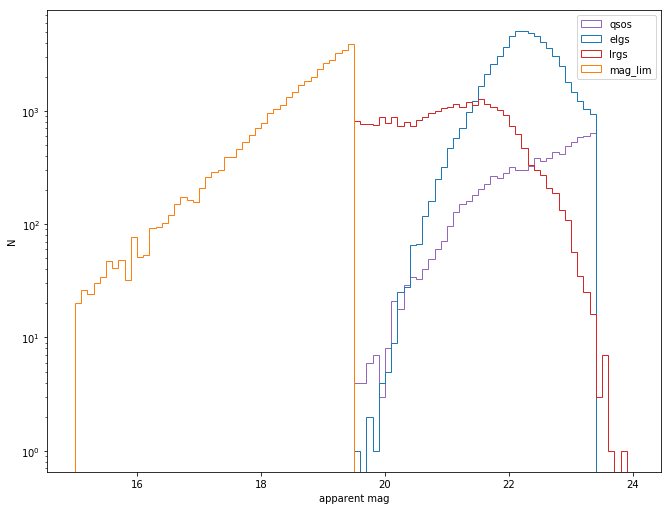

In [24]:
plt.figure(figsize=(11, 8.5))
plt.hist(qsos['mag_r_lsst'], bins=np.arange(15, 24.01, 0.1), histtype='step', label='qsos',
         color='C4')
plt.hist(elgs['mag_r_lsst'], bins=np.arange(15, 24.01, 0.1), histtype='step', label='elgs',
         color='C0')
plt.hist(lrgs['mag_r_lsst'], bins=np.arange(15, 24.01, 0.1), histtype='step',
         label='lrgs', color='C3')
plt.hist(magLim['mag_r_lsst'], bins=np.arange(15, 24.0, 0.1), histtype='step',
         label='mag_lim', color='C1')

# plt.hist(qsos['mag_z_lsst'], bins=np.arange(15, 24.01, 0.1), histtype='step',
#          ls='--', color='C4')
# plt.hist(elgs['mag_z_lsst'], bins=np.arange(15, 24.01, 0.1), histtype='step',
#          ls='--', color='C0')
# plt.hist(lrgs['mag_z_lsst'], bins=np.arange(15, 24.01, 0.1), histtype='step',
#          ls='--', color='C3')
# plt.hist(magLim['mag_z_lsst'], bins=np.arange(15, 24.0, 0.1), histtype='step',
#          ls='--', color='C1')

plt.semilogy()
plt.legend(loc=0)
plt.xlabel('apparent mag')
plt.ylabel('N')

Text(0,0.5,'r-i')

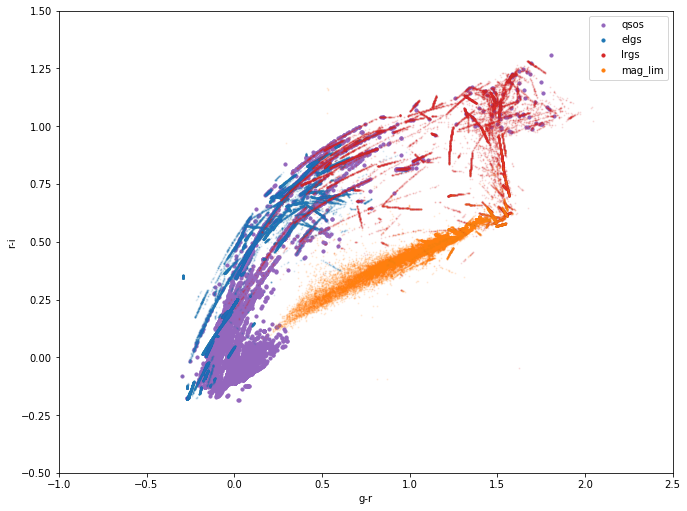

In [25]:
plt.figure(figsize=(11, 8.5))
plt.scatter(qsos['mag_g_lsst'] - qsos['mag_r_lsst'],
            qsos['mag_r_lsst'] - qsos['mag_i_lsst'],
            alpha=1, s=10, color='C4', label='qsos')
plt.scatter(elgs['mag_g_lsst'] - elgs['mag_r_lsst'],
            elgs['mag_r_lsst'] - elgs['mag_i_lsst'],
            alpha=0.1, s=1, color='C0')
plt.scatter([-100],
            [-100],
            s=10, color='C0', label='elgs')
plt.scatter(lrgs['mag_g_lsst'] - lrgs['mag_r_lsst'],
            lrgs['mag_r_lsst'] - lrgs['mag_i_lsst'],
            alpha=0.1, s=1, color='C3')
plt.scatter([-100],
            [-100],
            s=10, color='C3', label='lrgs')
plt.scatter(magLim['mag_g_lsst'] - magLim['mag_r_lsst'],
            magLim['mag_r_lsst'] - magLim['mag_i_lsst'],
            alpha=0.1, s=1, color='C1')
plt.scatter([-100],
            [-100],
            s=10, color='C1', label='mag_lim')
plt.xlim(-1, 2.5)
plt.ylim(-0.5, 1.5)
plt.legend()
plt.xlabel('g-r')
plt.ylabel('r-i')

Text(0,0.5,'g-r')

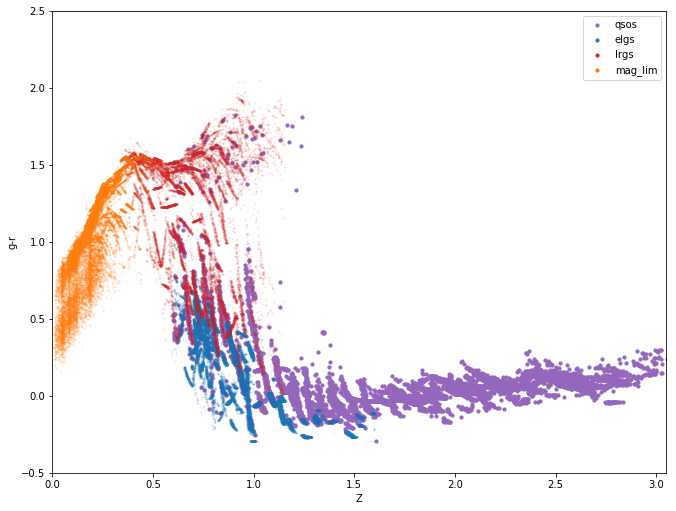

In [26]:
plt.figure(figsize=(11, 8.5))
plt.scatter(qsos['redshift'], qsos['mag_g_lsst'] - qsos['mag_r_lsst'],
            alpha=1, s=10, color='C4', label='qsos')
plt.scatter([-100],
            [-100],
            s=10, color='C0', label='elgs')
plt.scatter(elgs['redshift'], elgs['mag_g_lsst'] - elgs['mag_r_lsst'],
            alpha=0.1, s=1, color='C0')
plt.scatter([-100],
            [-100],
            s=10, color='C3', label='lrgs')
plt.scatter(lrgs['redshift'], lrgs['mag_g_lsst'] - lrgs['mag_r_lsst'],
            alpha=0.1, s=1, color='C3')
plt.scatter([-100],
            [-100],
            s=10, color='C1', label='mag_lim')
plt.scatter(magLim['redshift'], magLim['mag_g_lsst'] - magLim['mag_r_lsst'],
            alpha=0.1, s=1, color='C1')
plt.xlim(0, 3.05)
plt.ylim(-0.5, 2.5)
plt.legend()
plt.xlabel('Z')
plt.ylabel('g-r')

Now that we've run for the test region, we can produce objects for the full `_image` area. Currently the full 5k square degrees is not accessable due to space limitations.

In [30]:
base_dir = '/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/COSMODC2v1.1.4/PZCalibrate_image'

full_catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

full_catalog.add_derived_quantity('qsoness', qsoness, 'blackHoleMass', 'blackHoleEddingtonRatio')
full_catalog.add_derived_quantity('not_qsoselection',
                                  not_qsoselection,
                                  'redshift',
                                  'mag_r_lsst',
                                  'mag_r_lsst',
                                  'qsoness')
full_catalog.add_derived_quantity('not_elgselection',
                                  not_elgselection,
                                  'redshift',
                                  'mag_r_lsst',
                                  'mag_r_lsst',
                                  'totalStarFormationRate',
                                  'not_qsoselection')
full_catalog.add_derived_quantity('not_lrgselection',
                                  not_lrgselection,
                                  'redshift',
                                  'mag_z_lsst',
                                  'mag_r_lsst',
                                  'stellar_mass',
                                  'not_qsoselection',
                                  'not_elgselection')
full_catalog.add_derived_quantity('mag_limit',
                                  magnitude_limit,
                                  'mag_r_lsst')

pzCalib_iter = full_catalog.get_quantities(['not_qsoselection', 'not_elgselection',
                                            'not_lrgselection', 'mag_limit'],
                                            return_iterator=True)
fpath_iterator = full_catalog._healpix_files.values()

In [31]:
for data, fpath_original in zip(pzCalib_iter, fpath_iterator):
    
    pz_calib_out = dict()

    pz_calib_out['QSO'] = np.logical_not(data['not_qsoselection'])

    pz_calib_out['ELG'] = np.logical_not(data['not_elgselection'])
    mask = np.logical_or(pz_calib_out['QSO'], pz_calib_out['ELG'])

    pz_calib_out['LRG'] = np.logical_not(data['not_lrgselection'])
    mask = np.logical_or(mask, pz_calib_out['LRG'])

    pz_calib_out['MagLim'] = data['mag_limit']
    mask = np.logical_or(mask, pz_calib_out['MagLim'])
    
    pz_calib_out['AllReferences'] = mask
    
    fname_base, ext = os.path.splitext(os.path.basename(fpath_original))
    assert ext == '.hdf5' # this is just a sanity check
    fpath = os.path.join(base_dir, fname_base + '_pz_calib')
    
    fname_base, ext = os.path.splitext(os.path.basename(fpath_original))
    assert ext == '.hdf5' # this is just a sanity check
    fpath = os.path.join(base_dir, fname_base + '_pz_calib')
    
    np.savez(fpath, **pz_calib_out)

In [32]:
print('done?')

done?
